# 🫁 Swin Transformer Tiny - Chest X-ray Multi-Label Classification

**Dataset:** CheXpert 4-class (Cardiomegaly, Edema, Pneumothorax, No Finding)

**Model:** Swin Transformer Tiny (pretrained on ImageNet)

**Outputs:**
- 4 Binary Classification Reports (one per class)
- 4 Binary Confusion Matrices (one per class)
- Training/Validation Loss & Accuracy Curves
- ROC Curves for all 4 classes

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Torchvision
import torchvision.transforms as transforms
from torchvision.models import swin_t, Swin_T_Weights

# Sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, accuracy_score, f1_score,
    precision_score, recall_score
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## ⚙️ Configuration

In [2]:
class Config:
    # Paths - UPDATE THIS TO YOUR DATASET NAME
    DATA_DIR = "/kaggle/input/chest-xray-4class-100k"  # Your uploaded dataset
    OUTPUT_DIR = "/kaggle/working"
    
    # Model
    MODEL_NAME = "swin_transformer_tiny"
    NUM_CLASSES = 4
    LABELS = ["Cardiomegaly", "Edema", "Pneumothorax", "No Finding"]
    
    # Training
    BATCH_SIZE = 32
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    
    # Image
    IMG_SIZE = 224
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Random seed
    SEED = 42

config = Config()

# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(config.SEED)

print(f"🖥️ Device: {config.DEVICE}")
print(f"🤖 Model: {config.MODEL_NAME}")
print(f"🏷️ Labels: {config.LABELS}")

🖥️ Device: cuda
🤖 Model: swin_transformer_tiny
🏷️ Labels: ['Cardiomegaly', 'Edema', 'Pneumothorax', 'No Finding']


## 📦 Dataset Class

In [3]:
class ChestXrayDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.labels = config.LABELS
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get image path
        img_path = row['new_path']
        full_path = os.path.join(self.img_dir, img_path)
        
        # Load image
        try:
            image = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {full_path}: {e}")
            image = Image.new('RGB', (config.IMG_SIZE, config.IMG_SIZE), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        # Get labels (multi-hot encoding)
        labels = []
        for label in self.labels:
            val = row[label] if label in row.index else 0
            labels.append(1.0 if val == 1.0 else 0.0)
        
        labels = torch.tensor(labels, dtype=torch.float32)
        
        return image, labels

## 🔄 Data Transforms

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

## 📊 Load Data

In [5]:
print("=" * 60)
print("LOADING DATA")
print("=" * 60)

# Check what's in the data directory
print(f"\nContents of {config.DATA_DIR}:")
for item in os.listdir(config.DATA_DIR):
    print(f"  {item}")

# Load metadata
metadata_path = os.path.join(config.DATA_DIR, "metadata.csv")
df = pd.read_csv(metadata_path)
print(f"\n📈 Total samples: {len(df)}")

# Check label distribution
print("\n📊 Label distribution:")
for label in config.LABELS:
    if label in df.columns:
        count = (df[label] == 1.0).sum()
        print(f"  {label}: {count} ({count/len(df)*100:.2f}%)")

LOADING DATA

Contents of /kaggle/input/chest-xray-4class-100k:
  images
  metadata.csv

📈 Total samples: 95060

📊 Label distribution:
  Cardiomegaly: 23451 (24.67%)
  Edema: 49717 (52.30%)
  Pneumothorax: 17700 (18.62%)
  No Finding: 17000 (17.88%)


In [6]:
# Split data
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=config.SEED, 
    stratify=None  # Multi-label doesn't support stratify easily
)

print(f"🏋️ Train samples: {len(train_df)}")
print(f"🧪 Validation samples: {len(val_df)}")

# Create datasets
train_dataset = ChestXrayDataset(train_df, config.DATA_DIR, train_transform)
val_dataset = ChestXrayDataset(val_df, config.DATA_DIR, val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True
)

print(f"\n✅ DataLoaders created!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

🏋️ Train samples: 76048
🧪 Validation samples: 19012

✅ DataLoaders created!
   Train batches: 2377
   Val batches: 595


## 🤖 Model Definition

In [7]:
class SwinTransformerChestXray(nn.Module):
    def __init__(self, num_classes=4, pretrained=True):
        super().__init__()
        
        # Load pretrained Swin Transformer Tiny
        if pretrained:
            weights = Swin_T_Weights.IMAGENET1K_V1
            self.backbone = swin_t(weights=weights)
        else:
            self.backbone = swin_t(weights=None)
        
        # Get the number of features from the backbone
        in_features = self.backbone.head.in_features
        
        # Replace the classification head
        self.backbone.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

# Create model
model = SwinTransformerChestXray(num_classes=config.NUM_CLASSES, pretrained=True)
model = model.to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:00<00:00, 214MB/s]


📊 Total parameters: 27,915,134
📊 Trainable parameters: 27,915,134


## 🎯 Training Setup

In [8]:
# Loss function (BCE for multi-label)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY
)

# Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS, eta_min=1e-6)

print("✅ Training setup complete!")
print(f"   Loss: BCEWithLogitsLoss")
print(f"   Optimizer: AdamW (LR={config.LEARNING_RATE})")
print(f"   Scheduler: CosineAnnealingLR")

✅ Training setup complete!
   Loss: BCEWithLogitsLoss
   Optimizer: AdamW (LR=0.0001)
   Scheduler: CosineAnnealingLR


## 🔧 Training Functions

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Collect predictions
        preds = torch.sigmoid(outputs).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(loader)
    
    # Calculate accuracy (threshold = 0.5)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    binary_preds = (all_preds > 0.5).astype(int)
    accuracy = (binary_preds == all_labels).mean()
    
    return epoch_loss, accuracy

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(probs)
            all_preds.extend((probs > 0.5).astype(int))
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    
    # Calculate accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    accuracy = (all_preds == all_labels).mean()
    
    return epoch_loss, accuracy, all_preds, all_probs, all_labels

## 🏋️ Training Loop

In [10]:
print("=" * 60)
print("🚀 TRAINING STARTED")
print("=" * 60)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_loss = float('inf')
best_model_state = None

for epoch in range(config.NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, config.DEVICE
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_probs, val_labels = validate_epoch(
        model, val_loader, criterion, config.DEVICE
    )
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print metrics
    print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"📈 LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print("✅ Best model saved!")

# Load best model
model.load_state_dict(best_model_state)

# Save model
model_path = os.path.join(config.OUTPUT_DIR, "swin_transformer_chestxray.pth")
torch.save(best_model_state, model_path)
print(f"\n💾 Model saved to: {model_path}")

🚀 TRAINING STARTED

📅 Epoch 1/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:54<00:00,  5.20it/s]


📉 Train Loss: 0.3945 | Train Acc: 0.8257
📊 Val Loss: 0.3560 | Val Acc: 0.8440
📈 LR: 0.000100
✅ Best model saved!

📅 Epoch 2/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:59<00:00, 10.03it/s]


📉 Train Loss: 0.3493 | Train Acc: 0.8501
📊 Val Loss: 0.3417 | Val Acc: 0.8513
📈 LR: 0.000098
✅ Best model saved!

📅 Epoch 3/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:02<00:00,  9.45it/s]


📉 Train Loss: 0.3253 | Train Acc: 0.8625
📊 Val Loss: 0.3620 | Val Acc: 0.8481
📈 LR: 0.000097

📅 Epoch 4/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:03<00:00,  9.39it/s]


📉 Train Loss: 0.3020 | Train Acc: 0.8734
📊 Val Loss: 0.3467 | Val Acc: 0.8521
📈 LR: 0.000094

📅 Epoch 5/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:02<00:00,  9.48it/s]


📉 Train Loss: 0.2730 | Train Acc: 0.8884
📊 Val Loss: 0.3606 | Val Acc: 0.8516
📈 LR: 0.000091

📅 Epoch 6/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:59<00:00,  9.92it/s]


📉 Train Loss: 0.2416 | Train Acc: 0.9024
📊 Val Loss: 0.3803 | Val Acc: 0.8464
📈 LR: 0.000087

📅 Epoch 7/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:58<00:00, 10.22it/s]


📉 Train Loss: 0.2086 | Train Acc: 0.9176
📊 Val Loss: 0.4282 | Val Acc: 0.8474
📈 LR: 0.000082

📅 Epoch 8/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:56<00:00, 10.55it/s]


📉 Train Loss: 0.1800 | Train Acc: 0.9294
📊 Val Loss: 0.4889 | Val Acc: 0.8306
📈 LR: 0.000077

📅 Epoch 9/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:56<00:00, 10.61it/s]


📉 Train Loss: 0.1539 | Train Acc: 0.9408
📊 Val Loss: 0.4788 | Val Acc: 0.8399
📈 LR: 0.000072

📅 Epoch 10/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:58<00:00, 10.22it/s]


📉 Train Loss: 0.1330 | Train Acc: 0.9488
📊 Val Loss: 0.5130 | Val Acc: 0.8395
📈 LR: 0.000066

📅 Epoch 11/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:57<00:00, 10.39it/s]


📉 Train Loss: 0.1116 | Train Acc: 0.9571
📊 Val Loss: 0.5649 | Val Acc: 0.8355
📈 LR: 0.000060

📅 Epoch 12/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:55<00:00, 10.75it/s]


📉 Train Loss: 0.0964 | Train Acc: 0.9636
📊 Val Loss: 0.6001 | Val Acc: 0.8379
📈 LR: 0.000054

📅 Epoch 13/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:02<00:00,  9.52it/s]


📉 Train Loss: 0.0819 | Train Acc: 0.9696
📊 Val Loss: 0.6828 | Val Acc: 0.8352
📈 LR: 0.000047

📅 Epoch 14/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:55<00:00, 10.71it/s]


📉 Train Loss: 0.0697 | Train Acc: 0.9740
📊 Val Loss: 0.6936 | Val Acc: 0.8370
📈 LR: 0.000041

📅 Epoch 15/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:05<00:00,  9.06it/s]


📉 Train Loss: 0.0596 | Train Acc: 0.9776
📊 Val Loss: 0.7407 | Val Acc: 0.8376
📈 LR: 0.000035

📅 Epoch 16/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:04<00:00,  9.19it/s]


📉 Train Loss: 0.0509 | Train Acc: 0.9810
📊 Val Loss: 0.8039 | Val Acc: 0.8356
📈 LR: 0.000029

📅 Epoch 17/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:58<00:00, 10.14it/s]


📉 Train Loss: 0.0442 | Train Acc: 0.9836
📊 Val Loss: 0.9051 | Val Acc: 0.8364
📈 LR: 0.000024

📅 Epoch 18/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:11<00:00,  8.36it/s]


📉 Train Loss: 0.0377 | Train Acc: 0.9860
📊 Val Loss: 0.9977 | Val Acc: 0.8368
📈 LR: 0.000019

📅 Epoch 19/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:58<00:00, 10.15it/s]


📉 Train Loss: 0.0331 | Train Acc: 0.9877
📊 Val Loss: 1.0600 | Val Acc: 0.8341
📈 LR: 0.000014

📅 Epoch 20/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:08<00:00,  8.74it/s]


📉 Train Loss: 0.0290 | Train Acc: 0.9892
📊 Val Loss: 1.1211 | Val Acc: 0.8352
📈 LR: 0.000010

📅 Epoch 21/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:09<00:00,  8.51it/s]


📉 Train Loss: 0.0265 | Train Acc: 0.9902
📊 Val Loss: 1.1340 | Val Acc: 0.8358
📈 LR: 0.000007

📅 Epoch 22/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:53<00:00, 11.18it/s]


📉 Train Loss: 0.0243 | Train Acc: 0.9909
📊 Val Loss: 1.1929 | Val Acc: 0.8373
📈 LR: 0.000004

📅 Epoch 23/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:55<00:00, 10.67it/s]


📉 Train Loss: 0.0223 | Train Acc: 0.9917
📊 Val Loss: 1.1821 | Val Acc: 0.8352
📈 LR: 0.000003

📅 Epoch 24/25
----------------------------------------


Validation: 100%|██████████| 595/595 [00:55<00:00, 10.71it/s]


📉 Train Loss: 0.0210 | Train Acc: 0.9921
📊 Val Loss: 1.2352 | Val Acc: 0.8360
📈 LR: 0.000001

📅 Epoch 25/25
----------------------------------------


Validation: 100%|██████████| 595/595 [01:01<00:00,  9.68it/s]


📉 Train Loss: 0.0203 | Train Acc: 0.9925
📊 Val Loss: 1.2660 | Val Acc: 0.8353
📈 LR: 0.000001

💾 Model saved to: /kaggle/working/swin_transformer_chestxray.pth


## 📈 Plot Training Curves

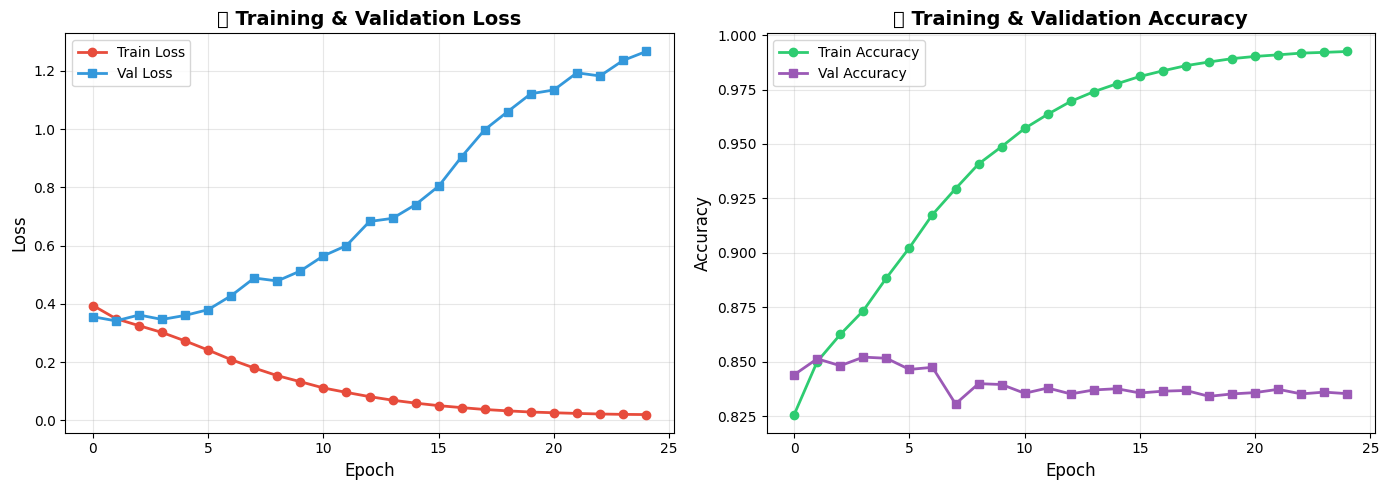

✅ Saved: training_curves.png


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='#e74c3c')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2, color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('📉 Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2, color='#2ecc71')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2, color='#9b59b6')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('📈 Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: training_curves.png")

## 🔍 Final Evaluation

In [12]:
print("=" * 60)
print("🔍 FINAL EVALUATION")
print("=" * 60)

# Get final predictions
val_loss, val_acc, all_preds, all_probs, all_labels = validate_epoch(
    model, val_loader, criterion, config.DEVICE
)

print(f"\n📊 Final Validation Loss: {val_loss:.4f}")
print(f"📊 Final Validation Accuracy: {val_acc:.4f}")

🔍 FINAL EVALUATION


Validation: 100%|██████████| 595/595 [00:54<00:00, 11.02it/s]


📊 Final Validation Loss: 1.2660
📊 Final Validation Accuracy: 0.8353


## 📊 4 Binary Confusion Matrices

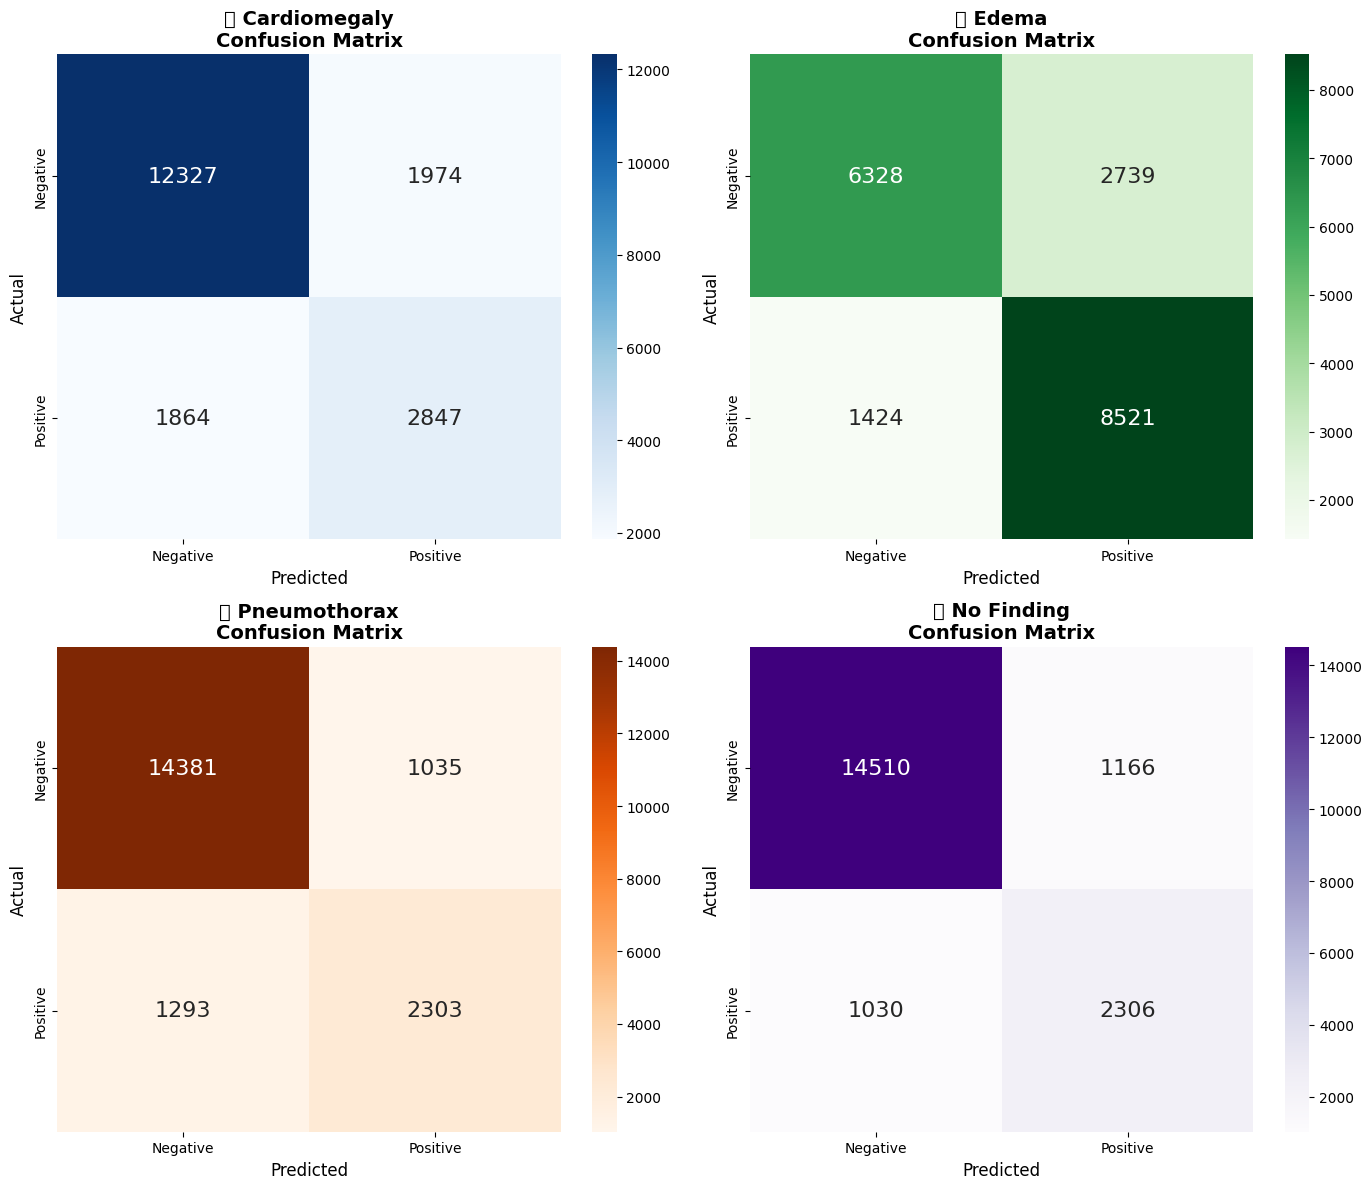

✅ Saved: confusion_matrices.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

colors = ['Blues', 'Greens', 'Oranges', 'Purples']

for i, label in enumerate(config.LABELS):
    # Get binary predictions and labels for this class
    class_preds = all_preds[:, i]
    class_labels = all_labels[:, i]
    
    # Compute confusion matrix
    cm = confusion_matrix(class_labels, class_preds)
    
    # Plot
    sns.heatmap(
        cm, annot=True, fmt='d', cmap=colors[i],
        xticklabels=['Negative', 'Positive'],
        yticklabels=['Negative', 'Positive'],
        ax=axes[i], annot_kws={'size': 16}
    )
    axes[i].set_xlabel('Predicted', fontsize=12)
    axes[i].set_ylabel('Actual', fontsize=12)
    axes[i].set_title(f'🏷️ {label}\nConfusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: confusion_matrices.png")

## 📋 4 Binary Classification Reports

In [14]:
print("=" * 60)
print("📋 CLASSIFICATION REPORTS (4 Binary)")
print("=" * 60)

reports = []

for i, label in enumerate(config.LABELS):
    print(f"\n{'='*50}")
    print(f"🏷️ CLASSIFICATION REPORT: {label}")
    print('='*50)
    
    class_preds = all_preds[:, i]
    class_labels = all_labels[:, i]
    
    # Print detailed report
    report = classification_report(
        class_labels, class_preds, 
        target_names=['Negative', 'Positive'],
        digits=4
    )
    print(report)
    
    # Calculate individual metrics
    acc = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)
    f1 = f1_score(class_labels, class_preds, zero_division=0)
    
    reports.append({
        'Label': label,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Create summary table
reports_df = pd.DataFrame(reports)
print("\n" + "=" * 60)
print("📊 SUMMARY TABLE")
print("=" * 60)
print(reports_df.to_string(index=False))

# Save reports to CSV
reports_df.to_csv(os.path.join(config.OUTPUT_DIR, 'classification_reports.csv'), index=False)
print("\n✅ Saved: classification_reports.csv")

📋 CLASSIFICATION REPORTS (4 Binary)

🏷️ CLASSIFICATION REPORT: Cardiomegaly
              precision    recall  f1-score   support

    Negative     0.8686    0.8620    0.8653     14301
    Positive     0.5905    0.6043    0.5974      4711

    accuracy                         0.7981     19012
   macro avg     0.7296    0.7331    0.7313     19012
weighted avg     0.7997    0.7981    0.7989     19012


🏷️ CLASSIFICATION REPORT: Edema
              precision    recall  f1-score   support

    Negative     0.8163    0.6979    0.7525      9067
    Positive     0.7567    0.8568    0.8037      9945

    accuracy                         0.7810     19012
   macro avg     0.7865    0.7774    0.7781     19012
weighted avg     0.7852    0.7810    0.7793     19012


🏷️ CLASSIFICATION REPORT: Pneumothorax
              precision    recall  f1-score   support

    Negative     0.9175    0.9329    0.9251     15416
    Positive     0.6899    0.6404    0.6643      3596

    accuracy                     

## 📊 Metrics Comparison Chart

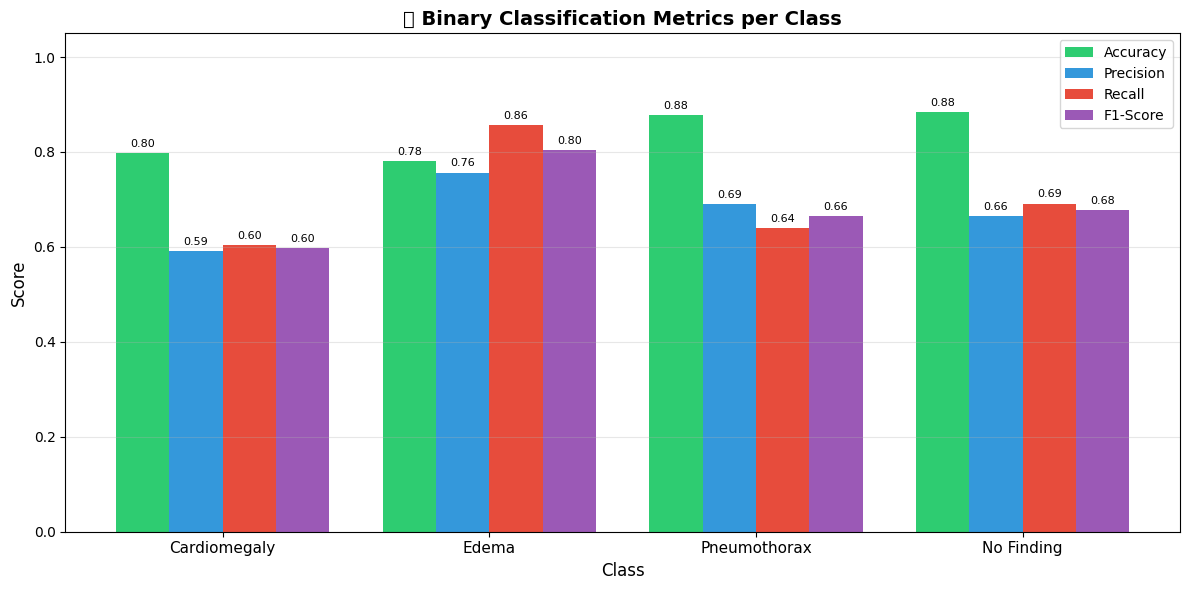

✅ Saved: metrics_comparison.png


In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(config.LABELS))
width = 0.2

bars1 = ax.bar(x - 1.5*width, reports_df['Accuracy'], width, label='Accuracy', color='#2ecc71')
bars2 = ax.bar(x - 0.5*width, reports_df['Precision'], width, label='Precision', color='#3498db')
bars3 = ax.bar(x + 0.5*width, reports_df['Recall'], width, label='Recall', color='#e74c3c')
bars4 = ax.bar(x + 1.5*width, reports_df['F1-Score'], width, label='F1-Score', color='#9b59b6')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('📊 Binary Classification Metrics per Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(config.LABELS, fontsize=11)
ax.legend(fontsize=10)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: metrics_comparison.png")

## 📈 ROC Curves for All 4 Classes

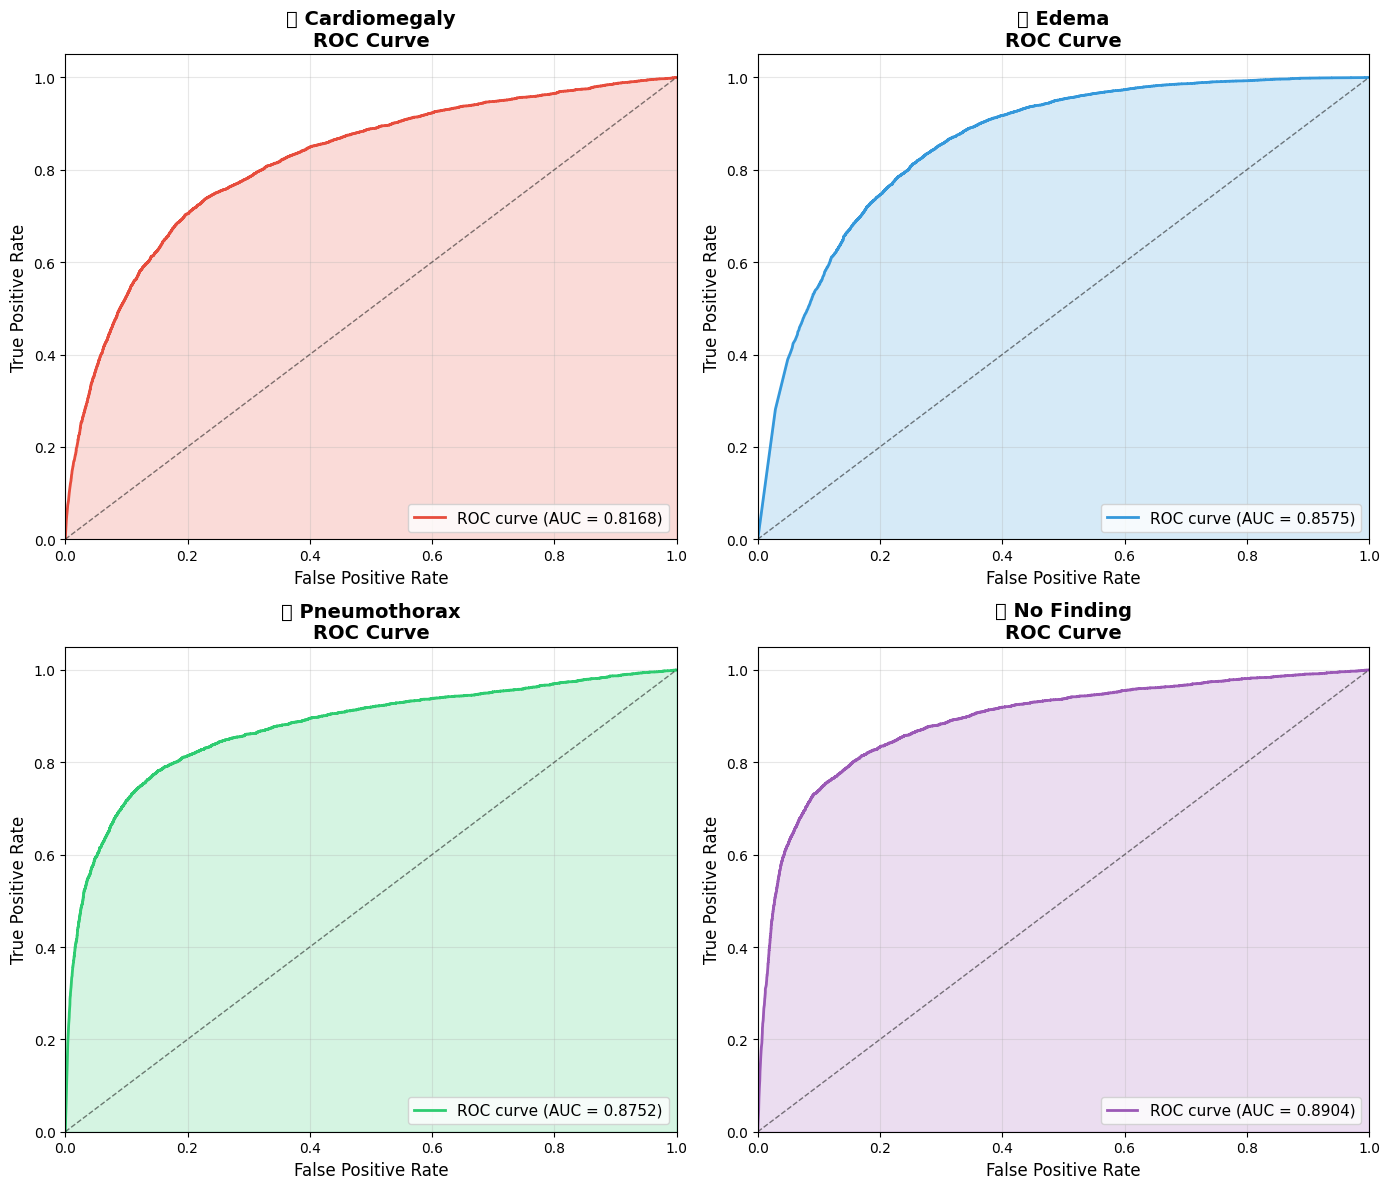

✅ Saved: roc_curves.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for i, label in enumerate(config.LABELS):
    class_probs = all_probs[:, i]
    class_labels = all_labels[:, i]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(class_labels, class_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    axes[i].plot(fpr, tpr, color=colors[i], linewidth=2, 
                 label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    axes[i].fill_between(fpr, tpr, alpha=0.2, color=colors[i])
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate', fontsize=12)
    axes[i].set_ylabel('True Positive Rate', fontsize=12)
    axes[i].set_title(f'🏷️ {label}\nROC Curve', fontsize=14, fontweight='bold')
    axes[i].legend(loc='lower right', fontsize=11)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: roc_curves.png")

## 🎉 Final Summary

In [17]:
print("=" * 60)
print("🎉 TRAINING COMPLETE!")
print("=" * 60)

print(f"""
🤖 Model: Swin Transformer Tiny
📊 Dataset: CheXpert (4-class: {', '.join(config.LABELS)})
🏋️ Training samples: {len(train_df)}
🧪 Validation samples: {len(val_df)}

📉 Best Validation Loss: {best_val_loss:.4f}
📈 Final Validation Accuracy: {val_acc:.4f}

📁 Output Files:
  📊 training_curves.png
  📊 confusion_matrices.png
  📊 metrics_comparison.png
  📊 roc_curves.png
  📄 classification_reports.csv
  🔧 swin_transformer_chestxray.pth

📋 Per-Class Performance:
""")

for _, row in reports_df.iterrows():
    print(f"  {row['Label']}: Acc={row['Accuracy']:.4f} | F1={row['F1-Score']:.4f}")

print("\n✅ All outputs saved successfully!")

🎉 TRAINING COMPLETE!

🤖 Model: Swin Transformer Tiny
📊 Dataset: CheXpert (4-class: Cardiomegaly, Edema, Pneumothorax, No Finding)
🏋️ Training samples: 76048
🧪 Validation samples: 19012

📉 Best Validation Loss: 0.3417
📈 Final Validation Accuracy: 0.8353

📁 Output Files:
  📊 training_curves.png
  📊 confusion_matrices.png
  📊 metrics_comparison.png
  📊 roc_curves.png
  📄 classification_reports.csv
  🔧 swin_transformer_chestxray.pth

📋 Per-Class Performance:

  Cardiomegaly: Acc=0.7981 | F1=0.5974
  Edema: Acc=0.7810 | F1=0.8037
  Pneumothorax: Acc=0.8776 | F1=0.6643
  No Finding: Acc=0.8845 | F1=0.6774

✅ All outputs saved successfully!
